# Movie Recommendation System

By: Anat Jacobson, Stephanie Ciaccia and Charlie Jin

---

## Overview

Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

The MovieLens dataset is a "classic" recommendation system dataset, that is used in numerous academic papers and machine learning proofs-of-concept. You will need to create the specific details about how the user will provide their ratings of other movies, in addition to formulating a more specific business problem within the general context of "recommending movies".

# Business Problem

Add business problem here

# Data Understanding

In [1]:
#importing packages

In [195]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline
import plotly.express as px
from matplotlib.ticker import StrMethodFormatter

from surprise.model_selection import cross_validate
from surprise import Dataset, Reader, accuracy
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline,  SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
import numpy as np

from collections import Counter
from nltk.corpus import stopwords

import pandas as pd
from IPython.display import display


Function for printing long lists

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

# Source #1: Grouplens

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for download at <http://grouplens.org/datasets/>.

### Import CSVs, Merge, and Clean all Data Needed
#### 4 Datasets imported:

- Movies:
- Links:
- Ratings:
- Tags:

In [137]:
#importing datasets
ratings_df = pd.read_csv("data/ratings.csv")
movies_df = pd.read_csv("data/movies.csv")
links_df = pd.read_csv("data/links.csv")
tags_df = pd.read_csv("data/tags.csv")

In [138]:
#checking the shape of all dfs
print('movies_df: ', movies_df.shape)
print('links_df: ',links_df.shape)
print('ratings_df: ',ratings_df.shape)
print('tags_df: ',tags_df.shape)

movies_df:  (9742, 3)
links_df:  (9742, 3)
ratings_df:  (100836, 4)
tags_df:  (3683, 4)


In [139]:
#attempting to make a loop of the above
# checking the shape of all dfs
# title = [movies_df, links_df, ratings_df, tags_df]
# for x in title:

#     print(f"'{x}: '", x.shape)

In [140]:
#displaying the first 5 rows of each data frames
display(movies_df.head())
display(links_df.head())
display(ratings_df.head())
display(tags_df.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [218]:
tag_group_df = tags_df.groupby(by="movieId").agg({"tag":" ".join})

In [219]:
#we would want to run a vectorizer and clean data
tag_group_df.value_counts()

tag                                                               
In Netflix queue                                                      109
Disney                                                                 15
aliens                                                                 10
Shakespeare                                                            10
Stephen King                                                            9
                                                                     ... 
death penalty Nun                                                       1
death penalty John Grisham                                              1
deafness                                                                1
darth vader luke skywalker space opera                                  1
"artsy" atmospheric gritty hallucinatory surreal visually stunning      1
Length: 1038, dtype: int64

### Inspecting ratings


In [141]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [142]:
ratings_df.userId.value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

### Inspecting movies

In [143]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [145]:
#splitting genre into multiple columns
genre_split = pd.DataFrame(movies_df.genres.str.split('|',6).tolist(),
                                 columns = ['genre_1','genre_2', 'genre_3',
                                            'genre_4', 'genre_5', 'genre_6', 'genre_7'])

#merging dataframes
movies_df = pd.merge(pd.DataFrame(movies_df), pd.DataFrame(genre_split), left_index=True, right_index=True)

#dropping genre columns
movies_df.drop(columns="genres", inplace=True)

In [222]:
genre_split

,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7
0,Adventure,Animation,Children,Comedy,Fantasy,None,None
1,Adventure,Children,Fantasy,None,None,None,None
2,Comedy,Romance,None,None,None,None,None
3,Comedy,Drama,Romance,None,None,None,None
4,Comedy,None,None,None,None,None,None
...,...,...,...,...,...,...,...
9737,Action,Animation,Comedy,Fantasy,None,None,None
9738,Animation,Comedy,Fantasy,None,None,None,None
9739,Drama,None,None,None,None,None,None
9740,Action,Animation,None,None,None,None,None


In [146]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genre_1  9742 non-null   object
 3   genre_2  6891 non-null   object
 4   genre_3  3673 non-null   object
 5   genre_4  1335 non-null   object
 6   genre_5  348 non-null    object
 7   genre_6  77 non-null     object
 8   genre_7  14 non-null     object
dtypes: int64(1), object(8)
memory usage: 685.1+ KB


In [147]:
#making year and title columns separate

#making year column
movies_df['year'] = movies_df['title'].str[-6:]

#making real_title column
movies_df['real_title'] = movies_df['title'].str[:-6]

#dropping original title column
movies_df = movies_df.drop(columns="title")

In [148]:
movies_df

,movieId,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,year,real_title
0,1,Adventure,Animation,Children,Comedy,Fantasy,None,None,(1995),Toy Story
1,2,Adventure,Children,Fantasy,None,None,None,None,(1995),Jumanji
2,3,Comedy,Romance,None,None,None,None,None,(1995),Grumpier Old Men
3,4,Comedy,Drama,Romance,None,None,None,None,(1995),Waiting to Exhale
4,5,Comedy,None,None,None,None,None,None,(1995),Father of the Bride Part II
...,...,...,...,...,...,...,...,...,...,...
9737,193581,Action,Animation,Comedy,Fantasy,None,None,None,(2017),Black Butler: Book of the Atlantic
9738,193583,Animation,Comedy,Fantasy,None,None,None,None,(2017),No Game No Life: Zero
9739,193585,Drama,None,None,None,None,None,None,(2017),Flint
9740,193587,Action,Animation,None,None,None,None,None,(2018),Bungo Stray Dogs: Dead Apple


### Inspecting links

The additional ids will be helpful so we can pull additional movie information from TMBD's api for the content based model.

In [149]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


### Inspecting tags

In [115]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


### Merging files into one dataframe for cleaning

In [154]:
#merging ratings, movies, and links
final_movies = pd.merge(ratings_df, movies_df, on="movieId", how="left")
final_movies = pd.merge(final_movies, links_df, on="movieId", how="left")

In [155]:
final_movies

,userId,movieId,rating,timestamp,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,year,real_title,imdbId,tmdbId
0,1,1,4.0,964982703,Adventure,Animation,Children,Comedy,Fantasy,None,None,(1995),Toy Story,114709,862.0
1,1,3,4.0,964981247,Comedy,Romance,None,None,None,None,None,(1995),Grumpier Old Men,113228,15602.0
2,1,6,4.0,964982224,Action,Crime,Thriller,None,None,None,None,(1995),Heat,113277,949.0
3,1,47,5.0,964983815,Mystery,Thriller,None,None,None,None,None,(1995),Seven (a.k.a. Se7en),114369,807.0
4,1,50,5.0,964982931,Crime,Mystery,Thriller,None,None,None,None,(1995),"Usual Suspects, The",114814,629.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Drama,Horror,Thriller,None,None,None,None,(2017),Split,4972582,381288.0
100832,610,168248,5.0,1493850091,Action,Crime,Thriller,None,None,None,None,(2017),John Wick: Chapter Two,4425200,324552.0
100833,610,168250,5.0,1494273047,Horror,None,None,None,None,None,None,(2017),Get Out,5052448,419430.0
100834,610,168252,5.0,1493846352,Action,Sci-Fi,None,None,None,None,None,(2017),Logan,3315342,263115.0


## Data Preparation - Cleaning

To being, we will need to remove null values and split the genre column so this can be One Hot Encoded.

In [157]:
#saving as new dataframe for cleaning
movie_df = final_movies

In [359]:
#checking for null values
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100823 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   100823 non-null  int64  
 1   movie_id  100823 non-null  int64  
 2   rating    100823 non-null  float64
 3   genre_1   100823 non-null  object 
 4   genre_2   100823 non-null  object 
 5   genre_3   100823 non-null  object 
 6   genre_4   100823 non-null  object 
 7   genre_5   100823 non-null  object 
 8   year      100823 non-null  object 
 9   title     100823 non-null  object 
 10  tmdbId    100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 11.7+ MB


In [160]:
#dropping genre columns that are mostly empty
movie_df = movie_df.drop(columns=["genre_6", "genre_7", "timestamp",
                                  "imdbId"])

In [161]:
#changing null value to 0 for genre id

genre_list = ["genre_2", "genre_3", "genre_4", "genre_5"]

for x in genre_list:
    movie_df[genre_list] = movie_df[genre_list].fillna(0)

In [162]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   rating      100836 non-null  float64
 3   genre_1     100836 non-null  object 
 4   genre_2     100836 non-null  object 
 5   genre_3     100836 non-null  object 
 6   genre_4     100836 non-null  object 
 7   genre_5     100836 non-null  object 
 8   year        100836 non-null  object 
 9   real_title  100836 non-null  object 
 10  tmdbId      100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


In [357]:
#checking nulls
movie_df.isna().sum()

user_id     0
movie_id    0
rating      0
genre_1     0
genre_2     0
genre_3     0
genre_4     0
genre_5     0
year        0
title       0
tmdbId      0
dtype: int64

In [166]:
#checking datatypes
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   rating      100836 non-null  float64
 3   genre_1     100836 non-null  object 
 4   genre_2     100836 non-null  object 
 5   genre_3     100836 non-null  object 
 6   genre_4     100836 non-null  object 
 7   genre_5     100836 non-null  object 
 8   year        100836 non-null  object 
 9   real_title  100836 non-null  object 
 10  tmdbId      100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


In [167]:
#dropping null values from dataframe
movie_df = movie_df.dropna()

In [168]:
#confirming null values and datatypes
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100823 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100823 non-null  int64  
 1   movieId     100823 non-null  int64  
 2   rating      100823 non-null  float64
 3   genre_1     100823 non-null  object 
 4   genre_2     100823 non-null  object 
 5   genre_3     100823 non-null  object 
 6   genre_4     100823 non-null  object 
 7   genre_5     100823 non-null  object 
 8   year        100823 non-null  object 
 9   real_title  100823 non-null  object 
 10  tmdbId      100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


In [169]:
#renaming columns for modeling
movie_df = movie_df.rename(columns={"userId":"user_id"})
movie_df = movie_df.rename(columns={"movieId":"movie_id"})
movie_df = movie_df.rename(columns={"real_title":"title"})

## Final Cleaned Dataset - movie_df

#### Features are:
- Genere
- Rating
- Tag

In [170]:
#reviewing final cleaned dataset
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100823 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   100823 non-null  int64  
 1   movie_id  100823 non-null  int64  
 2   rating    100823 non-null  float64
 3   genre_1   100823 non-null  object 
 4   genre_2   100823 non-null  object 
 5   genre_3   100823 non-null  object 
 6   genre_4   100823 non-null  object 
 7   genre_5   100823 non-null  object 
 8   year      100823 non-null  object 
 9   title     100823 non-null  object 
 10  tmdbId    100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


In [171]:
#exploring that dataset
movie_df.describe()

,user_id,movie_id,rating,tmdbId
count,100823.000000,100823.000000,100823.000000,100823.000000
mean,326.130823,19435.437737,3.501637,20105.462633
std,182.618176,35532.291269,1.042430,53274.143620
min,1.000000,1.000000,0.500000,2.000000
25%,177.000000,1199.000000,3.000000,712.000000
50%,325.000000,2991.000000,3.500000,6957.000000
75%,477.000000,8120.000000,4.000000,11635.000000
max,610.000000,193609.000000,5.000000,525662.000000


# Preliminary Analysis

In [172]:
#making dataframe of the top 15 users
top_15_reviewers = pd.DataFrame(movie_df["user_id"].value_counts(ascending=False).head(15))

#resetting index
top_15_reviewers = top_15_reviewers.reset_index()

#renaming columns based on value_counts
top_15_reviewers = top_15_reviewers.rename(columns={"user_id":"review_count"})
top_15_reviewers = top_15_reviewers.rename(columns={"index":"user_id"})

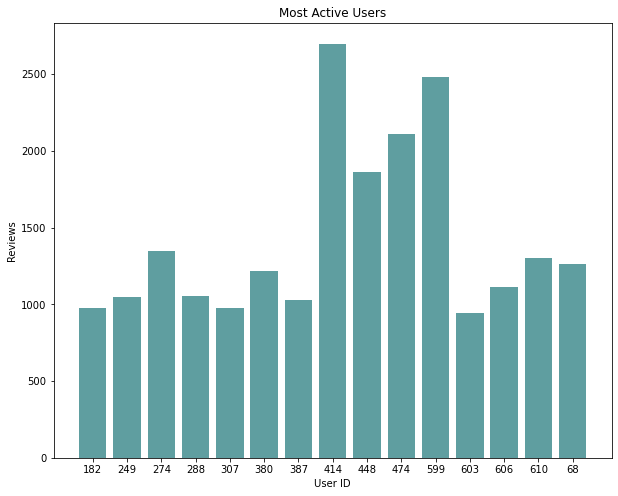

In [173]:
#making user_id a string for graphing
top_15_reviewers['user_id'] = top_15_reviewers['user_id'].astype(str)

#making sorted df for chart
top_15_sorted = top_15_reviewers.sort_values('review_count')

#making airbnb_rating a string

grouped = top_15_sorted.groupby("user_id")["review_count"].sum()

fig = plt.figure(figsize = (10, 8))

# create a bar plot
plt.bar(grouped.index, grouped.values, color="#5F9EA0")

# set the x-axis label
plt.xlabel("User ID")

# set the y-axis label
plt.ylabel("Reviews")

#adding title
plt.title("Most Active Users")

# show the plot
plt.show()

In [174]:
#making dataframe of rating counts to compare distribution of ratings
top_ratings = pd.DataFrame(movie_df["rating"].value_counts(ascending=False).head(15))
top_ratings = top_ratings.reset_index()
top_ratings = top_ratings.rename(columns={"rating":"rating_count"})
top_ratings = top_ratings.rename(columns={"index":"rating"})

#making user_id a string for plotting
top_ratings['rating'] = top_ratings['rating'].astype(str)

In [175]:
top_ratings

,rating,rating_count
0,4.0,26816
1,3.0,20044
2,5.0,13209
3,3.5,13134
4,4.5,8551
5,2.0,7550
6,2.5,5550
7,1.0,2811
8,1.5,1791
9,0.5,1367


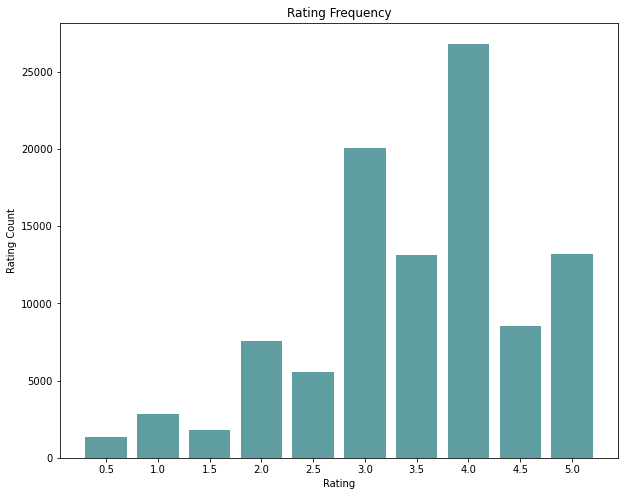

In [176]:
#making bar graph of rating frequency
grouped = top_ratings.groupby("rating")["rating_count"].sum()

fig = plt.figure(figsize = (10, 8))

# create a bar plot
plt.bar(grouped.index, grouped.values, color="#5F9EA0")

# set the x-axis label
plt.xlabel("Rating")

# set the y-axis label
plt.ylabel("Rating Count")

#adding title
plt.title("Rating Frequency")

# show the plot
plt.show()

In [177]:
#using plotly to plot the top featurescolor=
fig = px.bar(top_15_sorted, x="user_id", y="review_count")
fig.update_layout(title_text='Most Active Users', title_x=0.5,
                  xaxis_title="User Id", yaxis_title="Review Count")
fig.update_traces(marker_color = "#5F9EA0")
fig.show()

In [178]:
#using plotly to plot the top featurescolor=
fig = px.bar(top_ratings, x="rating", y="rating_count")
fig.update_layout(title_text='Rating Frequency', title_x=0.5,
                  xaxis_title="Rating", yaxis_title="Rating Count")
fig.update_traces(marker_color = "#5F9EA0")
fig.show()

# Model Preparation

With our dataset, we will need to perform user based collaborative filtering.

### Surprise Data

**Documentation for surprise**
- https://surprise.readthedocs.io/en/stable/dataset.html

additional resources
- https://www.analyticsvidhya.com/blog/2020/08/recommendation-system-k-nearest-neighbors/
- https://www.kaggle.com/code/ecemboluk/recommendation-system-with-cf-using-knn
- https://towardsdatascience.com/recommender-systems-and-hyper-parameter-tuning-25567b10e298

In [179]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100823 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   100823 non-null  int64  
 1   movie_id  100823 non-null  int64  
 2   rating    100823 non-null  float64
 3   genre_1   100823 non-null  object 
 4   genre_2   100823 non-null  object 
 5   genre_3   100823 non-null  object 
 6   genre_4   100823 non-null  object 
 7   genre_5   100823 non-null  object 
 8   year      100823 non-null  object 
 9   title     100823 non-null  object 
 10  tmdbId    100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


# Recommendation System Modeling

### Making new dataframe for surprise modeling with only neeeded columns

In [181]:
#dropping columns that aren't needed for Surprise (since )
surprise_df = movie_df.drop(columns=["title", "genre_1", "genre_2", "genre_3", "genre_4",
                                    "genre_5", "tmdbId", "year"])

In [182]:
#checking final dataframe
surprise_df

,user_id,movie_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [259]:
surprise_df['user_id'].value_counts()

414    2698
599    2478
474    2108
448    1863
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: user_id, Length: 610, dtype: int64

## Surprise Data and Train Test Split

#### Documentation for surprise
- https://surprise.readthedocs.io/en/stable/dataset.html

In [265]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1, 5))

#loading final dataset
data = Dataset.load_from_df(surprise_df, reader)

# Perform an appropriate split for the recommendation models
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [191]:
#looking at number of users
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items)

Number of users:  610 

Number of items:  8951


## Baseline Model

In [196]:
# Instantiate the model
baseline = NormalPredictor()

#fitting model
baseline.fit(trainset)

# making prediction on testset
predictions = baseline.test(testset)

# Save RMSE score
baseline_normal = accuracy.rmse(predictions)

RMSE: 1.4310


The Normal Predictor baseline model's Root Mean Squared Error (RMSE) tells us that our predicted rating is **1.43** points away from the actual rating.

In [197]:
# Instantiate and fit model
baseline2 = BaselineOnly()

#fitting model
baseline2.fit(trainset)

# making prediction on testset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8725


In [267]:
# Instantiate and fit model
baseline2 = BaselineOnly()

#fitting model
baseline2.fit(trainset)

# making prediction on testset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8725


The Baseline Only model's Root Mean Squared Error (RMSE) tells us that our predicted rating is **.875** points away from the actual rating. This is an improvement from the first model.

## Model #1 - SVD

We will be using Singular Value Decomposition (SVD) to reduce the dimensionality of our matrix.

In [202]:
# Cross validate a basic SVD with no hyperparameter tuning expecting sub-par results
svd_basic = SVD(random_state=42)

results = cross_validate(svd_basic, data, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8783  0.8784  0.8811  0.8793  0.0013  
Fit time          3.14    3.11    3.16    3.14    0.02    
Test time         0.16    0.16    0.16    0.16    0.00    


In [203]:
# Fit to trainset and predict on the testset for evaluation
svd_basic.fit(trainset)

predictions = svd_basic.test(testset)

svd_simple = accuracy.rmse(predictions)

RMSE: 0.8734


The SVD performed worse than the base model. Further tuning of the hyperparameters will need to be made.

## SVD Grid Search

https://towardsdatascience.com/recommender-systems-and-hyper-parameter-tuning-25567b10e298

With a SVD Grid Search, we will adjust the following hyperparameters:

- **n_factors:** Increasing the number of n_factors (latent features) will make the model more complex and could help with performance on the testing data. A number that is too high, could result in overfitting. 

- **n_epochs:** This adjusts the number of iterations that are run on the data. A value that is too low will underfit the model, while a value that is too high could result in overfitting. Since this is a large dataset, we will most likely end up with a higher number.

- **init_mean:** This adjusts the mean of the user

- **reg_all:**

- **biased:**

### Grid Search #1

In [208]:
#test grid search
params = {'n_factors': [10, 50, 100, 150, 200],
          'n_epochs': [10, 20],
          'init_mean': [-0.5, 0.5], 
          'reg_all': [.05, .01, 0.02],
         'biased': [True, False]}

g_s_svd = GridSearchCV(SVD, param_grid=params, cv=5, refit=True)

g_s_svd.fit(data)
g_s_svd.best_params['rmse']

{'n_factors': 10,
 'n_epochs': 20,
 'init_mean': 0.5,
 'reg_all': 0.02,
 'biased': False}

In [210]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8808879468723733, 'mae': 0.6758993339989241}
{'rmse': {'n_factors': 10, 'n_epochs': 20, 'init_mean': 0.5, 'reg_all': 0.02, 'biased': False}, 'mae': {'n_factors': 10, 'n_epochs': 20, 'init_mean': -0.5, 'reg_all': 0.01, 'biased': False}}


In [213]:
#saving best params
grid_1_best_params = g_s_svd.best_params['rmse']

In [214]:
grid_1_best_params

{'n_factors': 10,
 'n_epochs': 20,
 'init_mean': 0.5,
 'reg_all': 0.02,
 'biased': False}

In [271]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd = SVD(n_factors=10,n_epochs=20, init_mean=0.5, reg_all=0.02, biased=False)

# Fit on trainset and make predictions using testset to return RMSE metric
g_s_svd.fit(trainset)
predictions = g_s_svd.test(testset)
g_s_svd_1 = accuracy.rmse(predictions)

RMSE: 0.8771


## Grid Search #2

In [215]:
#test grid search
params_2 = {'n_factors': [10, 50, 100, 200, 300],
          'reg_all': [.05, .01, 0.02, .005],
         'n_epochs': [10, 20, 30]}

g_s_svd_2 = GridSearchCV(SVD, param_grid=params_2, cv=3, refit=True)

g_s_svd_2.fit(data)
g_s_svd_2.best_params['rmse']

{'n_factors': 10,
 'n_epochs': 10,
 'init_mean': 0.5,
 'reg_all': 0.01,
 'biased': False}

In [223]:
print(g_s_svd_2.best_score)
print(g_s_svd_2.best_params)

{'rmse': 0.8840175621942711, 'mae': 0.6787384404177316}
{'rmse': {'n_factors': 10, 'n_epochs': 10, 'init_mean': 0.5, 'reg_all': 0.01, 'biased': False}, 'mae': {'n_factors': 10, 'n_epochs': 10, 'init_mean': 0.5, 'reg_all': 0.01, 'biased': False}}


In [272]:
#saving best params
grid_2_best_params = g_s_svd_2.best_params['rmse']

In [273]:
grid_2_best_params

{'n_factors': 10,
 'n_epochs': 10,
 'init_mean': 0.5,
 'reg_all': 0.01,
 'biased': False}

In [275]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd_2 = SVD(n_factors=10, n_epochs=10, init_mean=0.5, reg_all=0.01, biased=False)

# Fit on trainset and make predictions using testset to return RMSE metric
g_s_svd_2.fit(trainset)
predictions = g_s_svd_2.test(testset)
g_s_svd_2_rmse = accuracy.rmse(predictions)

RMSE: 0.8791


### Grid Search #3

In [225]:
#test grid search
params_3 = {'n_factors': [50, 100, 200, 300, 400, 500, 600],
          'reg_all': [.005, .01, 0.02, .05],
         'n_epochs': [5, 10, 20, 30]}


g_s_svd_3 = GridSearchCV(SVD, param_grid=params_3, cv=5, refit=True)

g_s_svd_3.fit(data)

In [226]:
print(g_s_svd_3.best_score)
print(g_s_svd_3.best_params)

{'rmse': 0.862553467997772, 'mae': 0.6619182610970358}
{'rmse': {'n_factors': 100, 'reg_all': 0.05, 'n_epochs': 30}, 'mae': {'n_factors': 100, 'reg_all': 0.05, 'n_epochs': 30}}


In [276]:
g_s_svd_3_best_params = g_s_svd_3.best_params

In [277]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd_3 = SVD(n_factors=100, n_epochs=30, reg_all=0.05)

# Fit on trainset and make predictions using testset to return RMSE metric
g_s_svd_3.fit(trainset)
predictions = g_s_svd_3.test(testset)
g_s_svd_3_rmse = accuracy.rmse(predictions)

RMSE: 0.8611


### Grid Search #4

In [254]:
#test grid search
params_4 = {'n_factors': [400, 500],
          'reg_all': [.05],
           'n_epochs': [70, 80, 90]}

g_s_svd_4 = GridSearchCV(SVD, param_grid=params_6, cv=5, refit=True)

g_s_svd_4.fit(data)

In [255]:
print(g_s_svd_4.best_score)
print(g_s_svd_4.best_params)

{'rmse': 0.8527657695743092, 'mae': 0.6530799996445991}
{'rmse': {'n_factors': 500, 'reg_all': 0.05, 'n_epochs': 90}, 'mae': {'n_factors': 500, 'reg_all': 0.05, 'n_epochs': 90}}


In [278]:
g_s_svd_4_best_params = g_s_svd_6.best_params

In [270]:
# instantiating SVD with best hyperparameters from gridsearch
svd_best_model = SVD(n_factors=500, reg_all=0.05, n_epochs=90)

# Fit on trainset and make predictions using testset to return RMSE metric
svd_best_model.fit(trainset)
predictions = svd_best_model.test(testset)
svd_gs_best = accuracy.rmse(predictions)

RMSE: 0.8538


## SVD++ & Grid Searches

In [ ]:
#also try SVD ++
#can do cosine, pearson, or difference

In [236]:
#test grid search
params_svd_pp = {'n_factors': [40, 50, 100, 200, 300],
          'reg_all': [.05, .01, 0.02],
         'n_epochs': [10, 20, 30, 40]}

svdpp_model = GridSearchCV(SVDpp, param_grid=params_svd_pp, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)

# Fit and return the best_params
svdpp_model.fit(data)
svdpp_model.best_params['rmse']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_model = SVDpp(n_factors= , n_epochs=, random_state=42, reg_all=)

#fitting model
SVDpp_model.fit(trainset)

predictions = SVDpp_model.test(testset)

SVDpp_gs = accuracy.rmse(predictions)

### Model Comparison

### SVD Best Model

In [ ]:
svd_best_model = params_7 = {'n_factors': [100, 150, 200],
          'reg_all': [.05, .02],
           'n_epochs': [40, 50, 60, 70]}

g_s_svd_7 = GridSearchCV(SVD, param_grid=params_7, cv=5, refit=True)

g_s_svd_7.fit(data)

### Model Comparison

In [339]:
import plotly.express as px

#using plotly to plot the model RMSE scores
fig = px.bar(x=X, y=y, text=y, text_auto='.2')

fig.update_layout(
    title_text='Surprise Model Comparison',
    title_x=0.5,
    xaxis_title="Model",
    yaxis_title="RMSE",
    yaxis=dict(
        tick0=0.8,
        dtick=0.01,
        tickformat='.2f',
        range=[0.83, max(y)*1.01]
    )
)

fig.update_traces(marker_color="#5F9EA0", textposition="outside")

fig.show()

## Function